## Introduction
Leverage is a powerful tool that can significantly amplify the performance of a portfolio, but it also comes with the trade-off of increased risk. In this brief study, we focus on a daily-rebalanced Leveraged Exchange-Traded Fund (LETF). Due to daily re-leveraging, LETFs tend to be negatively impacted by periods of high volatility, a phenomenon known as volatility decay (see, e.g., Ref. 1). Conversely, LETFs can benefit from extended periods of low volatility and positive returns. The purpose of this study is to explore a potential strategy for identifying periods of low volatility, during which LETFs may outperform their underlying index.

### Note
Please note: if you are reading this notebook through GitHub, there is a chance that the figures will not display properly. Please open the markdown file "analysis.md".

### Disclaimer
The content provided here is for educational purposes only. It is not intended as financial advice or as a recommendation for any particular investment strategy.

## Methods
The strategy analyzed in this study involves rotating between a LETF and short-term bonds based on whether the LETF's underlying index is above or below its moving average. We consider various moving average periods to evaluate their impact. The index under consideration is the NASDAQ 100, and we analyze two LETFs: a 2x leveraged ETF (*Amundi Nasdaq-100 2x Daily Leveraged*, ticker: LQQ.PA) and a 3x leveraged ETF (*WisdomTree NASDAQ 100 3x Daily Leveraged*, ticker: QQQ3.MI).

<p style="text-align: center;">
<img src="fig_tickers.png" height="350" />
</p>

Please note that the y-label of the figure above is expressed in logarithmic scale.

## Analysis of the volatility
We first analyze the volatility of the NASDAQ 100 index from January 1, 1990, to October 1, 2024. Using a moving average window of length T, we evaluate the volatility of the index during periods when it is either above or below its moving average.

<p style="text-align: center;">
<img src="fig_volatility_comparison.png" height="350" />
</p>

The results of a Mann-Whitney U Test are provided in the code below. As shown in the figure, the index exhibits **significantly lower volatility when it is above its rolling average compared to when it is below**.

## Analysis of the strategy
The main parameter of the strategy is the length of the moving average window. A short window (e.g., 70 days) is more responsive to recent market changes, allowing for quicker adjustments but at the cost of more frequent trading and potential whipsawing. In contrast, a long window (e.g., 300 days) results in fewer trades and is less reactive to short-term market fluctuations, potentially providing more stability but being slower to adapt to new trends.

<p style="text-align: center;">
<img src="fig_volatility_vs_length_2x.png" height="200" />
<img src="fig_sharpe_vs_length_2x.png" height="200" />
</p>

<p style="text-align: center;">
<img src="fig_volatility_vs_length_3x.png" height="200" />
<img src="fig_sharpe_vs_length_3x.png" height="200" />
</p>

<p style="text-align: center;">
    <img src="fig_returns.png" height="200" />
</p>

<p style="text-align: center;">
<img src="fig_drawdowns.png" height="300" />
<img src="fig_returns_volatility.png" height="300" />
</p>

As shown in the analysis, both for the 2x and 3x LETF, the maximum Sharpe ratio is achieved with a moving average window of 199 days. This offers the best balance of responsiveness and stability in backtesting. According to this analysis, applying the rotating strategy to the 3x LETF would have been the optimal strategy in the past years. However, it is important to note that there is no guarantee this optimal condition will remain the same in the future.

## References
1. Gayed, Michael, Leverage for the Long Run - A Systematic Approach to Managing Risk and Magnifying Returns in Stocks (March 3, 2016). 2016 Charles H. Dow Award Updated Through December 31, 2020, Available at SSRN: https://ssrn.com/abstract=2741701 or http://dx.doi.org/10.2139/ssrn.2741701

In [10]:
# Importing necessary libraries for data handling, financial data retrieval, visualization, and statistical analysis
import matplotlib.pyplot as plt   # For data visualization
import yfinance as yf             # To fetch financial data
import numpy as np                # For numerical computations
import pandas as pd               # For data manipulation and analysis
import seaborn as sns             # For advanced visualizations
import scipy                      # For statistical analysis

[*********************100%***********************]  1 of 1 completed
 50-days period:  Above m.m.   | Below m.m.
     Volatility:  18.79%       | 27.21%
     pvalue:      1.1181049197977658e-09
 
100-days period:  Above m.m.   | Below m.m.
     Volatility:  19.57%       | 29.99%
     pvalue:      2.336177705793029e-16
 
200-days period:  Above m.m.   | Below m.m.
     Volatility:  21.85%       | 30.90%
     pvalue:      1.576857443338311e-18
 
300-days period:  Above m.m.   | Below m.m.
     Volatility:  20.06%       | 31.09%
     pvalue:      1.3274920818640852e-20
 


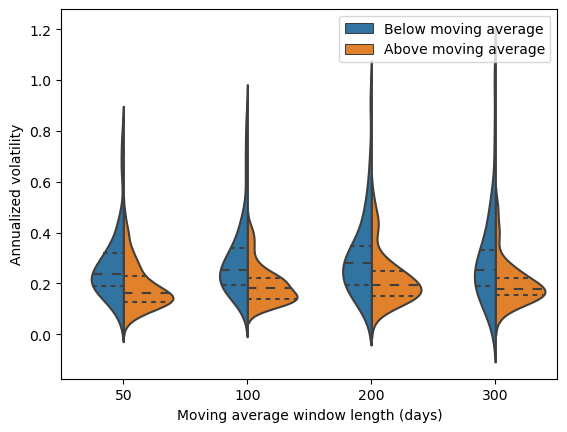

In [2]:
'''
Compare the volatility of the NASDAQ 100 (^NDX) during periods when it is above its moving average versus when it is below, 
across various moving average window lengths. This analysis is visualized using a violin plot.
'''

# Download NASDAQ 100 (^NDX) historical data from Yahoo Finance (1990-01-01 to 2024-10-01)
data = yf.download('^NDX',group_by='Date', start="1990-01-01", end="2024-10-01")
data['Pct Change'] = data['Adj Close'].pct_change()
num_years               = (data.index[-1]-data.index[0]).days/365
trading_days_in_year    = int(len(data.index)/num_years)

# Define moving average window lengths for comparison
window_lengths = [50, 100, 200, 300]
results        = pd.DataFrame()

# Loop over each window length to calculate volatility above and below the moving average
for window_length in window_lengths:
    # Generate signal to mark periods when the index is above its moving average
    above_moving_average = data['Adj Close']>data['Adj Close'].rolling(window = window_length).mean()

    periods_above = []
    periods_below = []

    i = 0
    while i<len(above_moving_average):
        # Identify periods below the moving average
        current_period = []
        while i<len(above_moving_average) and above_moving_average.iloc[i]==False:
            current_period.append(i)
            i+=1
        else:
            if len(current_period)>0:
                periods_below.append(current_period)
        # Identify periods above the moving average
        current_period = []
        while i<len(above_moving_average) and above_moving_average.iloc[i]==True:
            current_period.append(i)
            i+=1
        else:
            if len(current_period)>0:
                periods_above.append(current_period)
    
    volatilities_above = []
    volatilities_below = []

    # Calculate volatilities for periods above moving average
    for period in periods_above:
        if len(period)<6:
            # Skip short periods
            continue
        volatility  = data['Pct Change'].iloc[period].std() * (trading_days_in_year**0.5)
        results = results._append({'window': window_length, 'above': True, 'volatility': volatility, 'length': len(period)}, ignore_index=True)
        volatilities_above.append(volatility)
     # Calculate volatilities for periods below moving average
    for period in periods_below:
        if len(period)<6:
            # Skip short periods
            continue
        volatility  = data['Pct Change'].iloc[period].std() * (trading_days_in_year**0.5)
        results = results._append({'window': window_length, 'above': False, 'volatility': volatility, 'length': len(period)}, ignore_index=True)
        volatilities_below.append(volatility)

    # Perform Mann-Whitney U Test to compare volatilities
    Utest = scipy.stats.mannwhitneyu(results[results['above']==False]['volatility'], results[results['above']==True]['volatility'], alternative='greater')
    # Print results for the current window length
    print(f"{window_length:>3}-days period:  Above m.m.   | Below m.m.")
    print(f"     Volatility:  {100*np.mean(volatilities_above):.2f}%       | {100*np.mean(volatilities_below):.2f}%")
    print(f"     pvalue:      {Utest.pvalue}")
    print(" ")

# Create a violin plot to visualize the distribution of volatilities for each window length
p = sns.violinplot(data=results, x="window", y="volatility", hue="above",split=True, inner="quart")
handles, labels = p.get_legend_handles_labels()
p.legend(handles=handles, title="", labels=['Below moving average', 'Above moving average'])
plt.xlabel("Moving average window length (days)")
plt.ylabel("Annualized volatility")
plt.savefig('./fig_volatility_comparison.png')
plt.show()

[*********************100%***********************]  4 of 4 completed


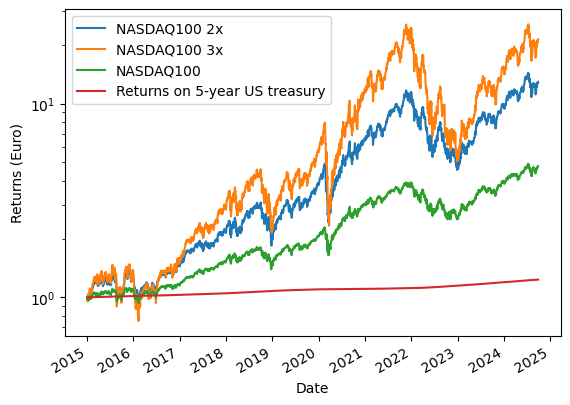

In [3]:
# Downloading and Processing Financial Data

# Tickers to download: 2x Leveraged NASDAQ100, 3x Leveraged NASDAQ100, NASDAQ100
tickers   = ["LQQ.PA", "QQQ3.MI", "^NDX"]
# US treasury yield (5 years) as the risk-free rate
risk_free = ["^FVX"]                     

# A dictionary of labels for the plotting section
labels = {"LQQ.PA": "NASDAQ100 2x", "QQQ3.MI": "NASDAQ100 3x", "^NDX": "NASDAQ100", "^FVX": "Returns on 5-year US treasury"}
# Download the data from Yahoo Finance (2015-01-01 to 2024-09-27)
data      = yf.download(tickers+risk_free,group_by='Date', start="2015-01-01", end="2024-09-27")

num_years               = (data.index[-1]-data.index[0]).days/365
trading_days_in_year    = int(len(data.index)/num_years)

# Process tickers: forward-fill missing data and compute daily percentage change for all tickers
for strategy in tickers:
    data[(strategy, 'Adj Close')] = data[(strategy, 'Adj Close')].ffill()
    data[(strategy,'Pct Change')] = data[(strategy, 'Adj Close')].pct_change()
# Process risk-free rate: convert yield to percentage change, adjust for trading days, and calculate cumulative product
for strategy in risk_free:
    data[(strategy, 'Adj Close')]  = data[(strategy, 'Adj Close')].ffill()
    data[(strategy, 'Pct Change')] = data[(strategy,'Adj Close')].div(100*trading_days_in_year)
    data[(strategy, 'Adj Close')]  = data[(strategy, 'Pct Change')].add(1).cumprod()
# Re-sort the columns by ticker after adding new columns
data.sort_index(axis=1, inplace=True) 

# Plot the cumulative product of percentage changes for all tickers and risk-free rate
for strategy in tickers+risk_free:
    data[(strategy,'Pct Change')].add(1).cumprod().plot(label=labels[strategy])

plt.yscale('log') # Set y-axis scale to logarithmic
plt.legend()
plt.ylabel("Returns (Euro)")
plt.savefig('./fig_tickers.png')
plt.show()

In [4]:
# Calculate Performance Metrics

# Print the period of analysis
print(f"Period: {num_years:.1f} years")

# Calculate the annualized risk-free return (5-year US Treasury yield)
riskfree_return =  ((data[('^FVX', 'Adj Close')].iloc[-1]/data[('^FVX', 'Adj Close')].iloc[0])**(1/num_years)-1)
print(f"Annualized risk-free return: {100*riskfree_return:.1f} %")

# Loop through each ticker and calculate performance metrics
for strategy in tickers:
    print(f"Ticker: {strategy}")

    # Calculate the excess returns, annualized standard deviation, and Sharpe ratio
    excess_returns      = (data[(strategy, 'Adj Close')].iloc[-1]/data[(strategy, 'Adj Close')].iloc[0])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[(strategy, 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation

    # Calculate the maximum drawdown
    current_max = maximum_drawdown= 0
    for i in range(len(data.index)):
        current_max = max(current_max, data[(strategy, 'Adj Close')].iloc[i])
        maximum_drawdown = min(maximum_drawdown, (data[(strategy, 'Adj Close')].iloc[i]-current_max)/current_max)
    
    # Print calculated metrics for the current ticker
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Maximum drowdown   = {-100*maximum_drawdown:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")

Period: 9.7 years
Annualized risk-free return: 2.2 %
Ticker: LQQ.PA
    Excess return      = 27.9 %
    Maximum drowdown   = 61.2 %
    Standard deviation = 39.7 %
    Sharpe ratio       = 0.70
-------
Ticker: QQQ3.MI
    Excess return      = 34.8 %
    Maximum drowdown   = 80.3 %
    Standard deviation = 59.6 %
    Sharpe ratio       = 0.58
-------
Ticker: ^NDX
    Excess return      = 15.2 %
    Maximum drowdown   = 35.6 %
    Standard deviation = 22.1 %
    Sharpe ratio       = 0.69
-------


In [5]:
# Strategy Backtest with Different Moving Average Windows

# Perform strategy backtest for different lengths of the moving average window
windows = [75, 150, 200, 250, 300]
results = []

for window_length in windows:
    # Generate a signal based on whether NASDAQ 100 is above its moving average
    above_moving_average = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = window_length).mean()
    
    # Apply strategy: invest in leveraged ETF when signal is True, otherwise invest in risk-free asset
    data[('MyStrategy', 'Pct Change')] = np.where(above_moving_average.shift(1), data[('LQQ.PA', 'Pct Change')], data[('^FVX', 'Pct Change')])
    data[('MyStrategy', 'Adj Close')] = data[('MyStrategy', 'Pct Change')].add(1).cumprod()

    # Calculate the number of years of the backtest
    num_years = (data.index[-1]-data.index[window_length]).days/365

    # Calculate excess returns, annualized volatility (standard deviation), and Sharpe ratio
    excess_returns      = (data[('MyStrategy', 'Adj Close')].iloc[-1]/data[('MyStrategy', 'Adj Close')].iloc[window_length])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[('MyStrategy', 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    
    # Print performance metrics for the current window length
    print(f"Window size: {window_length} days")
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")

Window size: 75 days
    Excess return      = 29.0 %
    Standard deviation = 27.8 %
    Sharpe ratio       = 1.04
-------
Window size: 150 days
    Excess return      = 34.2 %
    Standard deviation = 29.7 %
    Sharpe ratio       = 1.15
-------
Window size: 200 days
    Excess return      = 38.6 %
    Standard deviation = 29.6 %
    Sharpe ratio       = 1.30
-------
Window size: 250 days
    Excess return      = 35.2 %
    Standard deviation = 29.4 %
    Sharpe ratio       = 1.20
-------
Window size: 300 days
    Excess return      = 33.2 %
    Standard deviation = 30.0 %
    Sharpe ratio       = 1.11
-------


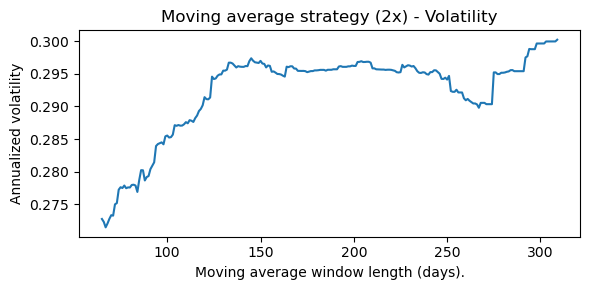

Maxium Sharpe ratio: 1.31 at day 199


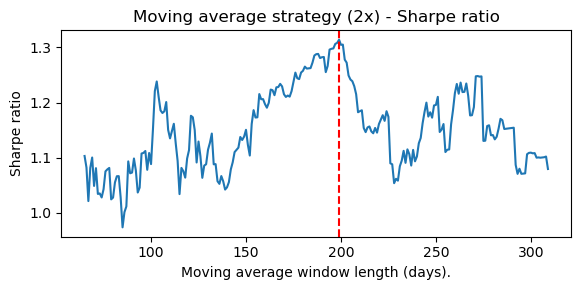

In [6]:
# The result of the cell above seems to indicate that a window of 200 days is optimal in backtest.
# Let's produce a plot of the relevant metrics vs the window size.

# Perform strategy backtest for different lengths of the moving average window
moving_average_windows = range(65, 310)
sharpe_ratios_list  = []
volatilities_list   = []

for window_length in moving_average_windows:
    # Generate a signal based on whether NASDAQ 100 is above its moving average
    above_moving_average = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = window_length).mean()
    
    # Apply strategy: invest in leveraged ETF when signal is True, otherwise invest in risk-free asset
    data[('MyStrategy', 'Pct Change')] = np.where(above_moving_average.shift(1), data[('LQQ.PA', 'Pct Change')], data[('^FVX', 'Pct Change')])
    data[('MyStrategy', 'Adj Close')] = data[('MyStrategy', 'Pct Change')].add(1).cumprod()

    # Calculate the number of years of the backtest
    num_years = (data.index[-1]-data.index[window_length]).days/365

    # Calculate excess returns, annualized volatility (standard deviation), and Sharpe ratio
    excess_returns      = (data[('MyStrategy', 'Adj Close')].iloc[-1]/data[('MyStrategy', 'Adj Close')].iloc[window_length])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[('MyStrategy', 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    
    # Print performance metrics for the current window length
    sharpe_ratios_list.append(sharpe_ratio)
    volatilities_list.append(standard_deviation)

plt.figure(figsize=(6, 3))
plt.plot(moving_average_windows, volatilities_list)
plt.xlabel("Moving average window length (days).")
plt.ylabel("Annualized volatility")
plt.title("Moving average strategy (2x) - Volatility")
plt.tight_layout()
plt.savefig('./fig_volatility_vs_length_2x.png')
plt.show()

maxv = maxi = 0
for i in range(len(sharpe_ratios_list)):
    if sharpe_ratios_list[i]>maxv:
        maxv = sharpe_ratios_list[i]
        maxi = i
print(f"Maxium Sharpe ratio: {maxv:.2f} at day {moving_average_windows[maxi]}")

plt.figure(figsize=(6, 3))
plt.plot(moving_average_windows, sharpe_ratios_list)
plt.axvline(x=moving_average_windows[maxi], color='red', linestyle='--', linewidth=1.5)  # Vertical line
plt.xlabel("Moving average window length (days).")
plt.ylabel("Sharpe ratio")
plt.title("Moving average strategy (2x) - Sharpe ratio")
plt.tight_layout()
plt.savefig('./fig_sharpe_vs_length_2x.png')
plt.show()



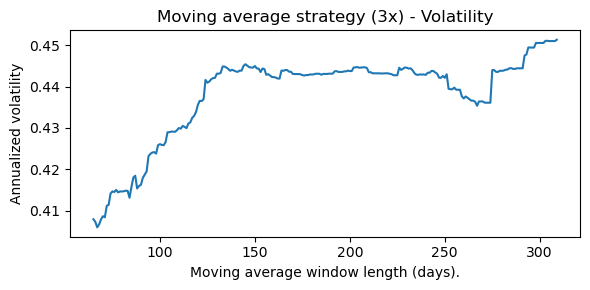

Maxium Sharpe ratio: 1.34 at day 199


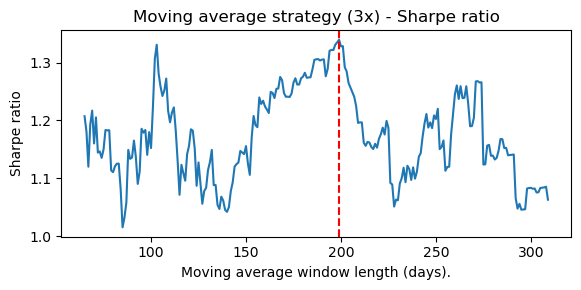

In [7]:
# We repeat the same analysis for the NASDAQ100 3x LETF
# Let's produce a plot of the relevant metrics vs the window size.

# Perform strategy backtest for different lengths of the moving average window
moving_average_windows = range(65, 310)
sharpe_ratios_list  = []
volatilities_list   = []

for window_length in moving_average_windows:
    # Generate a signal based on whether NASDAQ 100 is above its moving average
    above_moving_average = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = window_length).mean()
    
    # Apply strategy: invest in leveraged ETF when signal is True, otherwise invest in risk-free asset
    data[('MyStrategy', 'Pct Change')] = np.where(above_moving_average.shift(1), data[('QQQ3.MI', 'Pct Change')], data[('^FVX', 'Pct Change')])
    data[('MyStrategy', 'Adj Close')] = data[('MyStrategy', 'Pct Change')].add(1).cumprod()

    # Calculate the number of years of the backtest
    num_years = (data.index[-1]-data.index[window_length]).days/365

    # Calculate excess returns, annualized volatility (standard deviation), and Sharpe ratio
    excess_returns      = (data[('MyStrategy', 'Adj Close')].iloc[-1]/data[('MyStrategy', 'Adj Close')].iloc[window_length])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[('MyStrategy', 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    
    # Print performance metrics for the current window length
    sharpe_ratios_list.append(sharpe_ratio)
    volatilities_list.append(standard_deviation)

plt.figure(figsize=(6, 3))
plt.plot(moving_average_windows, volatilities_list)
plt.xlabel("Moving average window length (days).")
plt.ylabel("Annualized volatility")
plt.title("Moving average strategy (3x) - Volatility")
plt.tight_layout()
plt.savefig('./fig_volatility_vs_length_3x.png')
plt.show()

maxv = maxi = 0
for i in range(len(sharpe_ratios_list)):
    if sharpe_ratios_list[i]>maxv:
        maxv = sharpe_ratios_list[i]
        maxi = i
print(f"Maxium Sharpe ratio: {maxv:.2f} at day {moving_average_windows[maxi]}")

plt.figure(figsize=(6, 3))
plt.plot(moving_average_windows, sharpe_ratios_list)
plt.axvline(x=moving_average_windows[maxi], color='red', linestyle='--', linewidth=1.5)  # Vertical line
plt.xlabel("Moving average window length (days).")
plt.ylabel("Sharpe ratio")
plt.title("Moving average strategy (3x) - Sharpe ratio")
plt.tight_layout()
plt.savefig('./fig_sharpe_vs_length_3x.png')
plt.show()



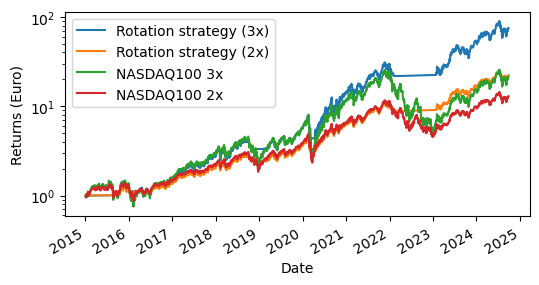

In [8]:

above_moving_average = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = 199).mean()

data[('MyStrategy_3x', 'Pct Change')] = np.where(above_moving_average.shift(1), data[('QQQ3.MI', 'Pct Change')], data[('^FVX', 'Pct Change')])
data[('MyStrategy_3x', 'Adj Close')] = data[('MyStrategy_3x', 'Pct Change')].add(1).cumprod()
data[('MyStrategy_2x', 'Pct Change')] = np.where(above_moving_average.shift(1), data[('LQQ.PA', 'Pct Change')], data[('^FVX', 'Pct Change')])
data[('MyStrategy_2x', 'Adj Close')] = data[('MyStrategy_2x', 'Pct Change')].add(1).cumprod()

plt.figure(figsize=(6, 3))
data[('MyStrategy_3x','Pct Change')].add(1).cumprod().plot(label = "Rotation strategy (3x)")
data[('MyStrategy_2x','Pct Change')].add(1).cumprod().plot(label = "Rotation strategy (2x)")
data[('QQQ3.MI','Pct Change')].add(1).cumprod().plot(label = "NASDAQ100 3x")
data[('LQQ.PA','Pct Change')].add(1).cumprod().plot(label = "NASDAQ100 2x")

plt.yscale('log') # Set y-axis scale to logarithmic
plt.ylabel("Returns (Euro)")
plt.legend()
plt.savefig('./fig_returns.png')


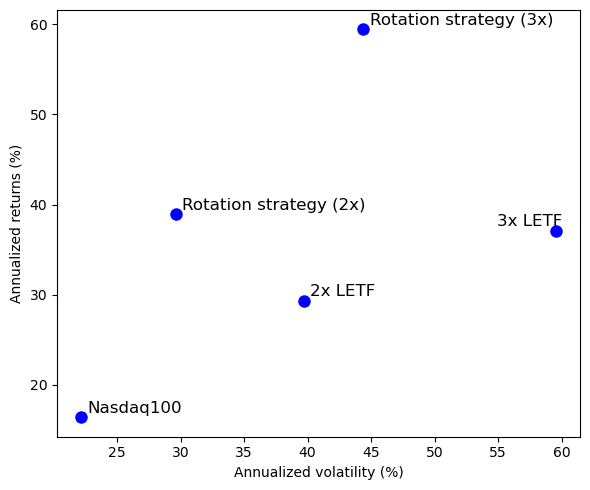

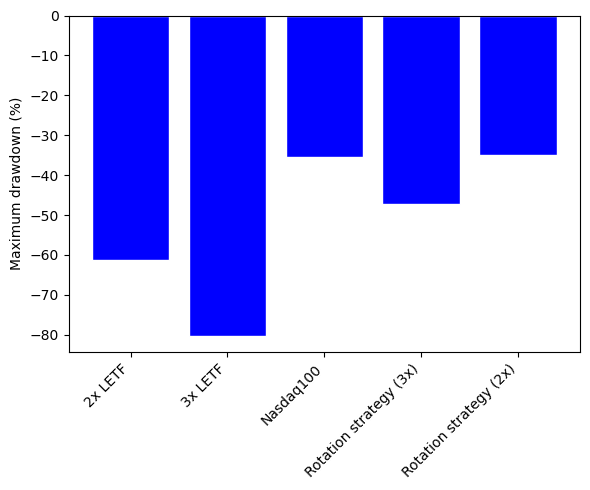

In [9]:
# Calculate performance metrics (excess returns, standard deviation, Sharpe ratio, and maximum drawdown)
# for various strategies and visualize them in a scatter plot.

labels = {"LQQ.PA": "2x LETF", "QQQ3.MI":"3x LETF", "^NDX": "Nasdaq100", "MyStrategy_3x": "Rotation strategy (3x)", "MyStrategy_2x": "Rotation strategy (2x)"}
orientations = {"LQQ.PA": "left", "QQQ3.MI":"right", "^NDX": "left", "MyStrategy_3x": "left", "MyStrategy_2x": "left"}

drawdowns = {}

plt.figure(figsize=(6, 5))

for strategy in ["LQQ.PA", "QQQ3.MI", "^NDX", "MyStrategy_3x", "MyStrategy_2x"]:

    # Calculate the excess returns, annualized standard deviation, and Sharpe ratio
    num_years = (data.index[-1]-data.index[199]).days/365

    excess_returns      = (data[(strategy, 'Adj Close')].iloc[-1]/data[(strategy, 'Adj Close')].iloc[199])**(1/num_years)-1 - riskfree_return
    standard_deviation  = data[(strategy, 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation

    # Calculate the maximum drawdown
    current_max = maximum_drawdown= 0
    for i in range(len(data.index)):
        current_max = max(current_max, data[(strategy, 'Adj Close')].iloc[i])
        maximum_drawdown = min(maximum_drawdown, (data[(strategy, 'Adj Close')].iloc[i]-current_max)/current_max)
    
    # Used for the bar plot
    drawdowns[labels[strategy]] = maximum_drawdown*100
    '''# Print calculated metrics for the current ticker
    print(f"Ticker: {strategy}")
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Maximum drowdown   = {-100*maximum_drawdown:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")'''
    plt.scatter(standard_deviation*100, excess_returns*100, s=100, alpha=1, edgecolors='w', color='blue', label=strategy)  # s is the size of the circles
    plt.annotate(labels[strategy], (standard_deviation*100+.5, excess_returns*100+.5), fontsize=12, ha=orientations[strategy])
    
plt.xlabel("Annualized volatility (%)")
plt.ylabel("Annualized returns (%)")
plt.tight_layout()  
plt.savefig('./fig_returns_volatility.png')
plt.show()

plt.figure(figsize=(6, 5))
plt.bar(list(drawdowns.keys()), list(drawdowns.values()), color='blue', edgecolor='w')  
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
plt.ylabel("Maximum drawdown (%)")
plt.tight_layout() 
plt.savefig('./fig_drawdowns.png')
plt.show()
